# A discrete mixing model for worker skills

This notebook uses a discrete mixing model to perform unsupervised clustering of profiles from an online freelance labor market called UpWork. Workers provide a list of their skills, and the learned clusters correspond to particular "types" of workers -- at a broad level, coders, web developers, designers, writers, and office workers. The dataset is described in more details in Anderson, Katharine A., (2018). “Skill Networks and Measures of Complex Human Capital” Proceedings of the National Academy of Science, 201706597.

This small project arose out of conversations with Dr. Anderson. She and a collaborator wanted to include skill data in some reduced form in a model of the labor market. They used $k$-means for clustering, and had trouble with a "giant" cluster that included about half of the workers, and did not have a clean qualitative description. I figured a mixing model could do better.

The discrete mixing model is similar to a Gaussian mixing model, in that the underlying model for workers first assigns them a type, which we cannot directly observe, then assigns observable features based on that type. In the Gaussian model each type corresponds to a multivariate normal distribution. In this discrete model, each type corresponds to a vector of probabilities for having each skill. The skill assignments are then treated as independent Bernoulli trials (conditional on type).

I couldn't find a nice Python library for fitting this sort of model, so I implemented the expectation-maximization algorithm myself. The model takes in a number of clusters, then returns a vector of skill probabilities for each cluster. In the following we print the most probable skills, and see that they make sense qualitatively. In fitting the model we also generate an estimate of the type assignment for each worker, which can have support in multiple types. We look at those below and find that the discrete mixing model successfully classifies most workers, with only a small fraction ambiguously classified. As one might expect, the greatest degeneracy is between the coders and web-developers, and between writers and office workers.

The primary run below has five clusters, since this provided a good comparison with previous work that used $k$-means. A run with $k=10$ shows that the clusters are still qualitatively sound for higher $k$. We have not done the cross-validation required to determine on optimal $k$, since our goal was to produce a manageable number of clusters, rather than the finest possible partitioning of the dataset.

### Setting up Jupyter

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas

In [3]:
from numpy import max

### Loading Skills Data

In [4]:
pkl_file = pandas.read_pickle("wave2_worker_dataframe.pkl")

In [5]:
skill_df = pkl_file.loc[:,'skills']

In [6]:
skill_count = dict()
for i in range(len(skill_df)):
    for j in range(len(skill_df[i])):
        try:
            skill_count[skill_df[i][j]] += 1
        except KeyError:
            skill_count[skill_df[i][j]] = 1

In [7]:
len(skill_count)

1921

In [8]:
n_sk = len(skill_count)
skill_names = list()
skcnt = list()
for key,value in skill_count.iteritems():
    skill_names.append(key)
    skcnt.append(value)
skcnt = array(skcnt)
order = skcnt.argsort()[::-1]
skrnk = order.argsort()

`skill_ranks` is a dictionary that takes in skills and produces a rank. `rank_to_skill` is a dictionary that takes in a rank and produces the name of the corresponding skill. My hope is that sorting the skills by rank will make it easier to compare clusters.

In [9]:
skill_ranks = dict()
for i in range(len(skill_names)):
    skill_ranks[skill_names[i]] = skrnk[i]
rank_to_skill = { v:k for k,v in skill_ranks.items() }

We restrict our analysis to skills that appeared 40 or more times. As one might expect, there is a long tail of very rare skills. Since we have limited information about how these skills fit into clusters they tend to degrade the analysis, which is why we have excluded them.

In [10]:
skill_cut = 40
f = where(skcnt>=skill_cut)

nf = len(f[0])
no = len(skill_df)

observations = zeros((no,nf))

for i in range(no):
    for j in range(len(skill_df[i])):
        current_skill = skill_df[i][j]
        if skill_count[current_skill] >= skill_cut:
            feature_index = skill_ranks[current_skill]
            observations[i,feature_index] = 1

In [15]:
nf,no

(276, 7934)

There are a handful of people who do not have any of the most-common skills. We remove them from the analysis at this point.

In [18]:
num_skills = sum(observations,axis=1)
skilled = where(num_skills>0)[0]
observations = observations[skilled]

no = len(observations)
print nf,no

276 7878


A log plot of skill frequency, sorted by skill rank.

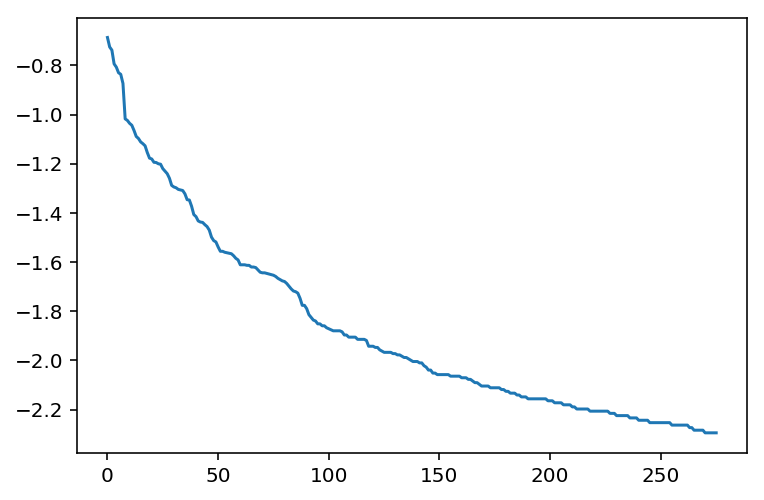

In [30]:
p_mean = 1.0 * sum(observations,axis=0)/no
plot(log10(p_mean))

### Bernoulli Mixture Model Functions

I've departed from the standard EM algorithm in a few ways. Around `#TINKERING` I've recentered $\log(f)$, which should improve numerical stability without changing the results. I've also added floors to push $p$ away from 0 or 1, and $\lambda$ away from very small values. Since we're working with logs, $p=0$ and $p=1$ cause the code to barf. A known issue with this type of model is a tendency to create "groups" with exactly one member, which the floor on $\lambda$ is intended to fix.

In [20]:
def feelthebern(k,observations):
    no = len(observations)
    nf = len(observations[0])
    
    #We're having trouble with p=0, p=1
    p_floor = 0.1/no
    
    #Also trouble with tiny groups
    lam_floor = 6./no
    
    #Initialize
    lam = ones(k)
    lam /= sum(lam)
    p = rand(k,nf)
    
    dq = 1000
    steps = 0
    
    logp = log(p)
    logq = log(1-p)
    
    while (dq>100) & (steps<20):
        steps += 1
        
        #E Step
        logfT = logp.dot(observations.T) + logq.dot(1-observations.T) + log(lam).reshape((k,1))
        #TINKERING
        logfT -= mean(logfT)
        #/TINKERING
        fT = exp(logfT)
        fT /= sum(fT,axis=0)

        #M Step
        fTX = fT.dot(observations)
        p_new = array(fTX)
        p_new /= sum(fT,axis=1).reshape((k,1))
        lam_new = sum(fT,axis=1)
        lam_new /= sum(lam_new)
        
        #New Flooring nonsense
        g = where(p_new<p_floor)
        p_new[g] = p_floor
        g = where(p_new>1-p_floor)
        p_new[g] = 1-p_floor
        g = where(lam_new<lam_floor)
        lam_new[g] = lam_floor
        lam_new /= sum(lam_new)

        #Convergence Check
        #print "Made it to dq"
        logp_new = log(p_new)
        logq_new = log(1-p_new)
        dq = sum( log(lam_new/lam).dot(fT) )
        dq += trace(fTX.dot(logp_new.T))
        dq -= trace(fTX.dot(logp.T))
        dq += trace( (sum(fT,axis=1).reshape(k,1) - fTX).dot(logq_new.T) )
        dq -= trace( (sum(fT,axis=1).reshape(k,1) - fTX).dot(logq.T) )
        #print steps,dq
        
        #Update
        p = array(p_new)
        logp = array(logp_new)
        logq = array(logq_new)
        lam = array(lam_new)    
    
    logfT = logp.dot(observations.T) + logq.dot(1-observations.T) + lam.reshape((k,1))
    fT = exp(logfT)
    fT /= sum(fT,axis=0)
    
    return p,lam,fT.T

In [21]:
def Q(p,lam,observations):
    no = len(observations)
    k = len(lam)

    logp = log(p)
    logq = log(1-p)
    
    logfT = logp.dot(observations.T) + logq.dot(1-observations.T) + log(lam).reshape((k,1))
    #TINKERING
    logfT -= mean(logfT)
    #/TINKERING
    fT = exp(logfT)
    fT /= sum(fT,axis=0)
    fTX = fT.dot(observations)
    
    q = sum( log(lam).dot(fT) )
    q += trace(fTX.dot(logp.T))
    q += trace( (sum(fT,axis=1).reshape(k,1) - fTX).dot(logq.T) )
    
    return q

### Fitting the Model: $k=5$

Do the fitting `reps` times, store the best-fit model in `p_vals` (vectors of probabilities of having each skill for each group), `lam_vals` (mixing weights), and `z_vals` (group membership probabilities for each person). We repeat this process `reps` times, since the EM algorithm only finds local maxima. We consider it a "failure" if one of the mixing weights is at the minimum value that we set above, and only retain successes. We retain the best fit found through these repetitions. At the end we print `lam_vals*number of people`, to get the expected number of members of each group.

In [22]:
reps = 100
k = 5

qval = 0
successes = 0
failures = 0

while successes < reps:
    kfit = feelthebern(k,observations)
    check = where(kfit[1]*no<7)[0]
    if len(check)>0:
        failures += 1
        continue
    else:
        successes += 1
        print successes,failures
        failures = 0
    q_temp = Q(kfit[0],kfit[1],observations)
    if (qval==0):
        qval = float(q_temp)
        p_vals = array(kfit[0])
        lam_vals = array(kfit[1])
        z_vals = array(kfit[2])
    elif (q_temp>qval):
        qval = float(q_temp)
        p_vals = array(kfit[0])
        lam_vals = array(kfit[1])
        z_vals = array(kfit[2])

set_printoptions(suppress=True)
print around(lam_vals*no,2)
set_printoptions(suppress=False)

1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 1
13 0
14 0
15 1
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 1
40 0
41 0
42 0
43 0
44 0
45 0
46 1
47 0
48 2
49 0
50 0
51 0
52 0
53 0
54 1
55 0
56 2
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 1
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 1
97 0
98 0
99 0
100 0
[1630.46 1854.26 1242.81 1410.05 1740.42]


Plot the `p_vals` vector for each group. These are normalized by the probability of seeing each skill in the full dataset. Mostly, we're looking to see that these vectors have support over lots of skills.

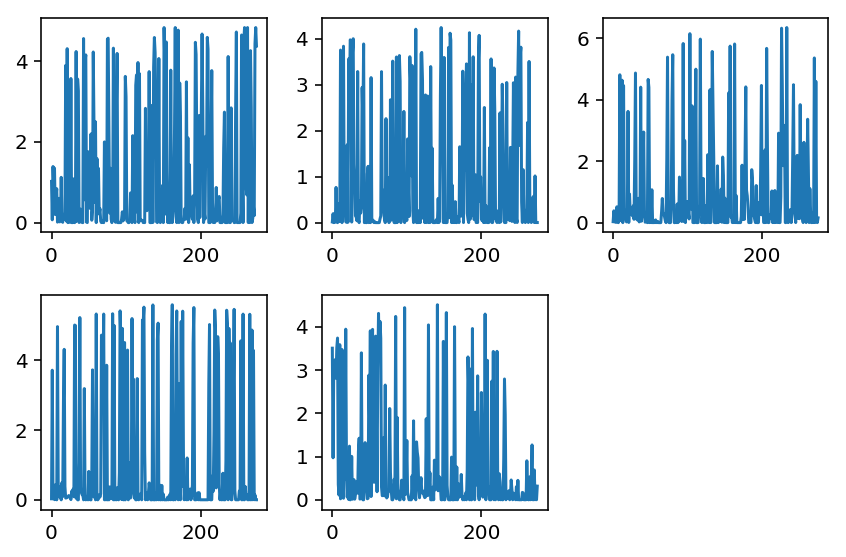

In [28]:
n_rows = 2
n_cols = 3
for i in range(k):
    subplot(n_rows,n_cols,i+1)
    plot(p_vals[i]/p_mean)
tight_layout()

Histogram of the largest of the `z_vals` for each person. When this is close to 1, the person is clearly assigned to a single group.

(0, 7878)

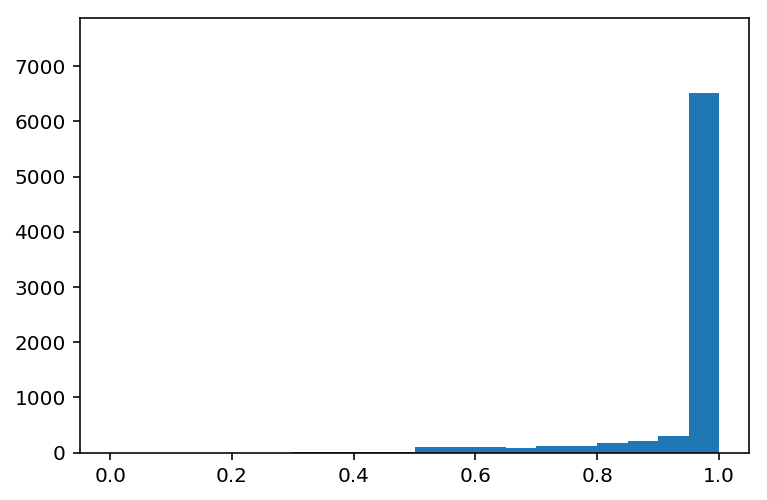

In [23]:
sz = sort(z_vals,axis=1)
hist(sz[:,-1],range=(0,1),bins=20)
ylim(0,no)

Pairwise plots of the `z_vals`. In blue are people who are (modally) in the first group, in red are people who are in the second group, and in gray are people who are in neither of those groups.

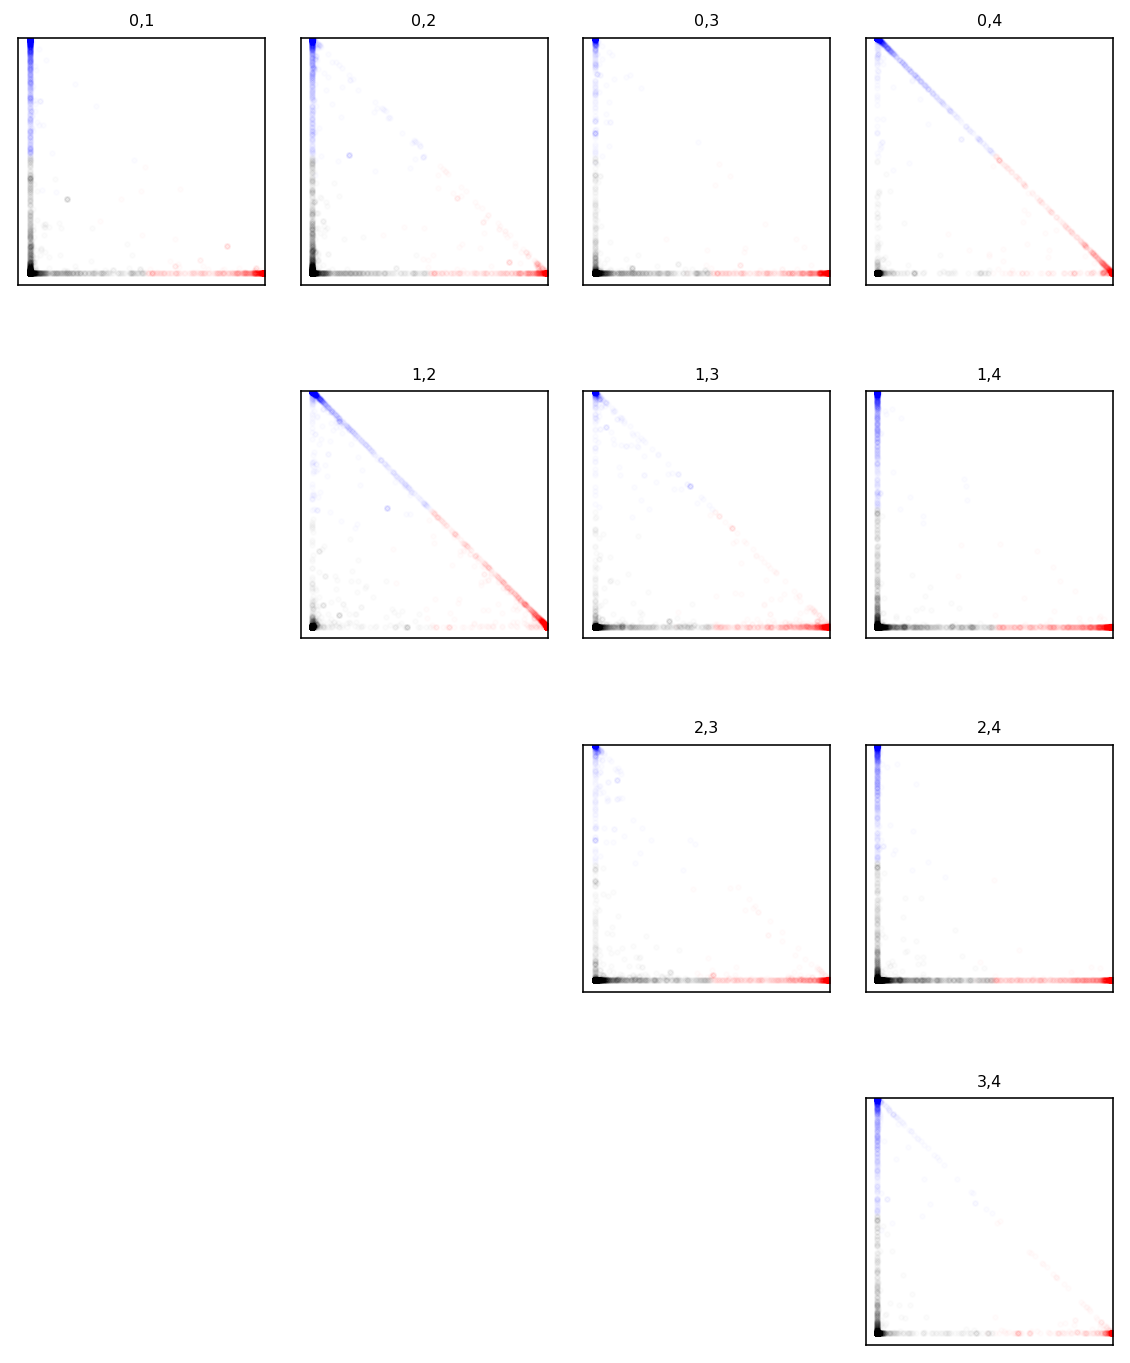

In [31]:
figure(figsize=(8,10))

z_max = max(z_vals,axis=1)

for i in range(k):
    for j in range(k):
        if i < j:
            gi = where(z_vals[:,i] == z_max)
            gj = where(z_vals[:,j] == z_max)
            gk = where( (z_vals[:,i] != z_max) & (z_vals[:,j] != z_max))
            
            a = subplot(k-1,k-1,(k-1)*i+j)
            #scatter(z_vals[:,i],z_vals[:,j],marker="+",alpha=0.1)
            scatter(z_vals[gi][:,i],z_vals[gi][:,j],marker=".",s=24,alpha=0.01,color='r')
            scatter(z_vals[gj][:,i],z_vals[gj][:,j],marker=".",s=24,alpha=0.01,color='b')
            scatter(z_vals[gk][:,i],z_vals[gk][:,j],marker=".",s=24,alpha=0.01,color='k')
            xlim(-0.05,1)
            ylim(-0.05,1)
            xticks([])
            yticks([])
            a.set_aspect(1)
            title("{},{}".format(i,j),fontsize=8)
            
tight_layout()

"Characteristic" skills for each group.

In [32]:
for my_k in range(k):
    print my_k,round(lam_vals[my_k]*no,2)
    
    for j in range(nf):
        if (p_vals[my_k,j] - p_mean[j])>0.1:
            print rank_to_skill[j]
    print "***"

0 1630.46
java
c#
sql
c++
linux-system-administration
python
.net-framework
android-app-development
asp.net
***
1 1854.26
article-writing
blog-writing
proofreading
seo
creative-writing
content-writing
editing
copywriting
social-media-marketing
copy-editing
***
2 1242.81
microsoft-excel
data-entry
microsoft-word
internet-research
customer-service
microsoft-powerpoint
administrative-support
virtual-assistant
***
3 1410.05
adobe-photoshop
adobe-illustrator
web-design
graphic-design
adobe-indesign
logo-design
illustration
adobe-after-effects
***
4 1740.42
php
javascript
html
mysql
wordpress
css
jquery
html5
ajax
css3
***


A longer list of characteristic skills for each group. Here we look at `p_vals / p_mean`, rather than `p_vals - p_mean`, so we get to see what's going on with rare skills.

In [33]:
for my_k in range(k):
    print my_k,round(lam_vals[my_k]*no,2)
    
    for j in range(nf):
        if (p_vals[my_k,j]/p_mean[j])>1.2:
            print rank_to_skill[j]
    print "***"

0 1630.46
javascript
mysql
java
c#
sql
c++
linux-system-administration
python
.net-framework
android-app-development
asp.net
angularjs
ruby-on-rails
ios-development
xml
postgresql
git
node.js
mongodb
c
objective-c
ruby
microsoft-access
asp.net-mvc
django-framework
iphone-app-development
windows-administration
amazon-web-services
actionscript-3
apache-administration
perl
network-administration
microsoft-visual-basic
lamp-administration
mobile-app-development
vba
database-modeling
j2ee
delphi
software-testing
unix-shell
wpf
amazon-ec2
spring-framework
data-mining
nginx
mac-os-app-development
wcf
unity-3d
hibernate
game-development
web-scraping
agile-software-development
api-development
facebook-api
swift
unix-system-administration
oop
software-qa-testing
google-maps-api
database-design
oracle-database
adobe-flex
data-scraping
jquery-mobile
qt
microsoft-sql-server-development
extjs
asp
redis
rest
cisco-routers
database-administration
computer-networking
apple-xcode
bash
statistics
virtual

### Fitting the Model: $k=10$

As explained above, we started with $k=5$ in order to match previous analyses and provide a convenient number of clusters. Increasing to $k=10$ is fun because we can see that the clusters are still qualitatively different.

In [34]:
reps = 100
k = 10

qval = 0
successes = 0
failures = 0

while successes < reps:
    kfit = feelthebern(k,observations)
    check = where(kfit[1]*no<7)[0]
    if len(check)>0:
        failures += 1
        continue
    else:
        successes += 1
        print successes,failures
        failures = 0
    q_temp = Q(kfit[0],kfit[1],observations)
    if (qval==0):
        qval = float(q_temp)
        p_vals = array(kfit[0])
        lam_vals = array(kfit[1])
        z_vals = array(kfit[2])
    elif (q_temp>qval):
        qval = float(q_temp)
        p_vals = array(kfit[0])
        lam_vals = array(kfit[1])
        z_vals = array(kfit[2])

set_printoptions(suppress=True)
print around(lam_vals*no,2)
set_printoptions(suppress=False)

1 0
2 0
3 1
4 1
5 1
6 0
7 0
8 0
9 2
10 0
11 0
12 0
13 1
14 0
15 1
16 1
17 0
18 0
19 0
20 0
21 0
22 2
23 0
24 2
25 0
26 1
27 0
28 0
29 2
30 0
31 0
32 3
33 1
34 2
35 1
36 0
37 2
38 1
39 1
40 1
41 0
42 4
43 1
44 0
45 1
46 0
47 0
48 1
49 0
50 0
51 0
52 0
53 2
54 0
55 0
56 0
57 0
58 2
59 1
60 2
61 0
62 1
63 2
64 0
65 0
66 0
67 0
68 1
69 0
70 1
71 3
72 7
73 0
74 0
75 4
76 0
77 0
78 1
79 0
80 0
81 0
82 0
83 0
84 4
85 0
86 0
87 1
88 1
89 0
90 1
91 1
92 1
93 3
94 0
95 0
96 1
97 0
98 0
99 0
100 0
[1994.53  445.37  385.44  441.78  930.49  602.71  824.37  895.74  716.2
  641.37]


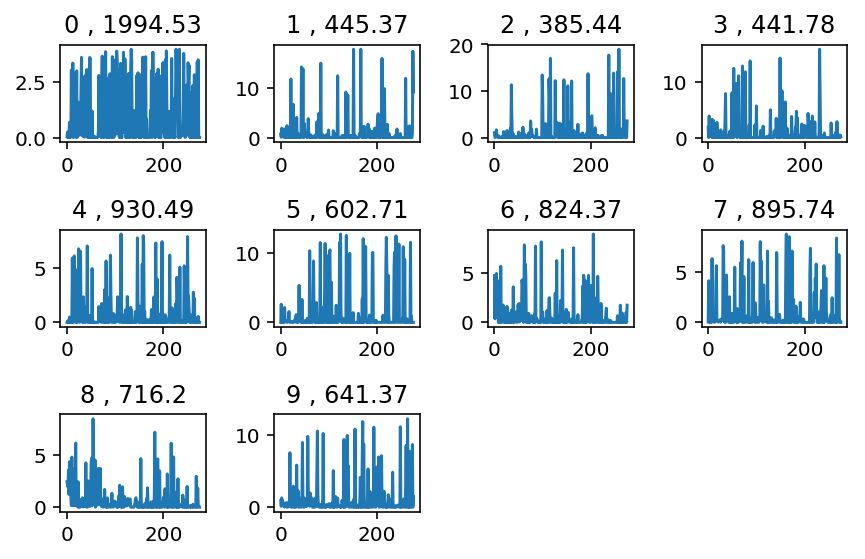

In [35]:
n_rows = 3
n_cols = 4
for i in range(k):
    subplot(n_rows,n_cols,i+1)
    plot(p_vals[i]/p_mean)
    title("{} , {}".format(i,round(lam_vals[i]*no,2)))
tight_layout()

(0, 7878)

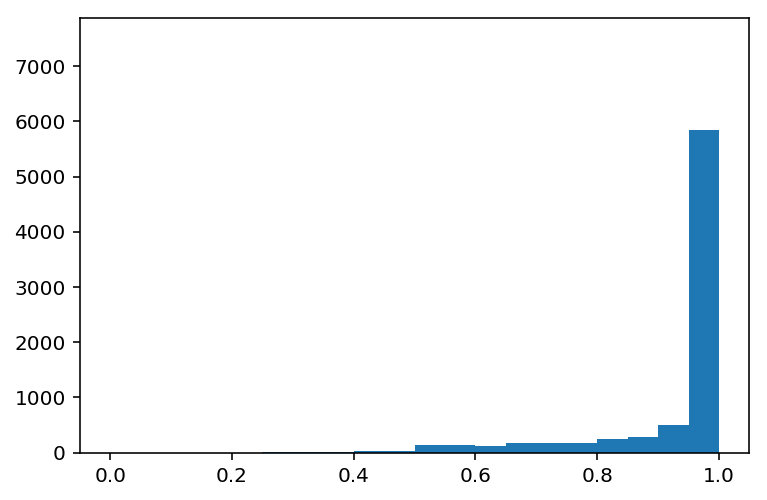

In [36]:
sz = sort(z_vals,axis=1)
hist(sz[:,-1],range=(0,1),bins=20)
ylim(0,no)

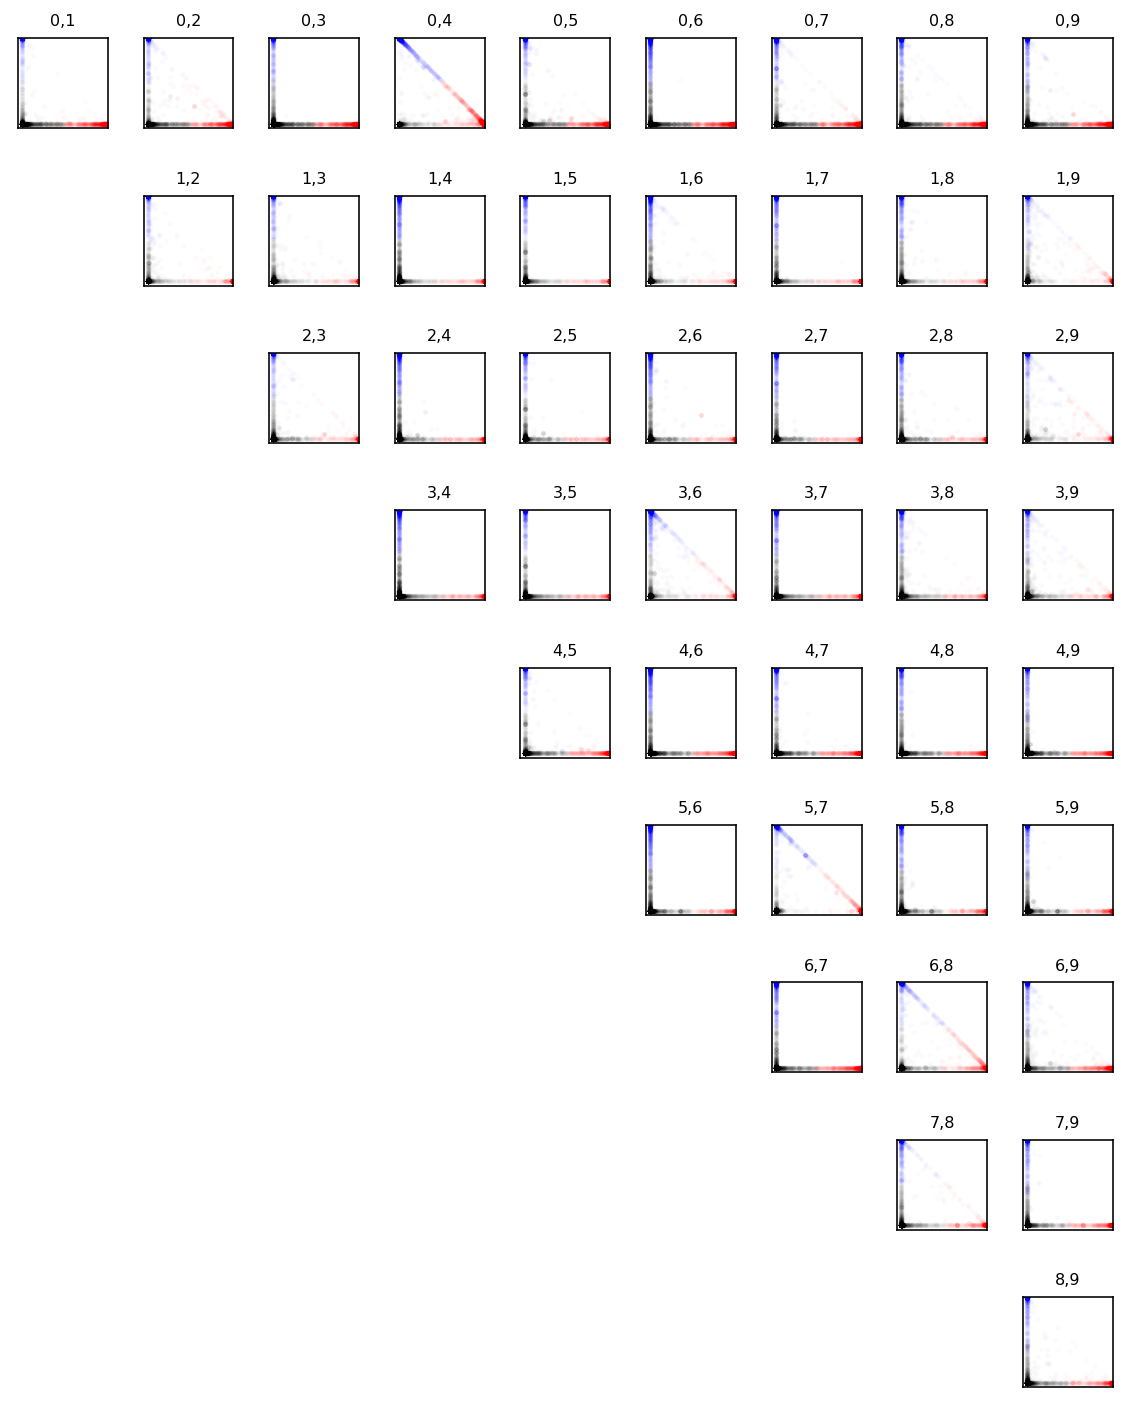

In [37]:
figure(figsize=(8,10))

z_max = max(z_vals,axis=1)

for i in range(k):
    for j in range(k):
        if i < j:
            gi = where(z_vals[:,i] == z_max)
            gj = where(z_vals[:,j] == z_max)
            gk = where( (z_vals[:,i] != z_max) & (z_vals[:,j] != z_max))
            
            a = subplot(k-1,k-1,(k-1)*i+j)
            #scatter(z_vals[:,i],z_vals[:,j],marker="+",alpha=0.1)
            scatter(z_vals[gi][:,i],z_vals[gi][:,j],marker=".",s=12,alpha=0.01,color='r')
            scatter(z_vals[gj][:,i],z_vals[gj][:,j],marker=".",s=12,alpha=0.01,color='b')
            scatter(z_vals[gk][:,i],z_vals[gk][:,j],marker=".",s=12,alpha=0.01,color='k')
            xlim(-0.05,1)
            ylim(-0.05,1)
            xticks([])
            yticks([])
            a.set_aspect(1)
            title("{},{}".format(i,j),fontsize=8)
            
tight_layout()

In [38]:
for my_k in range(k):
    print my_k,round(lam_vals[my_k]*no,2)
    
    for j in range(nf):
        if (p_vals[my_k,j] - p_mean[j])>0.1:
            print rank_to_skill[j]
    print "***"

0 1994.53
microsoft-excel
data-entry
microsoft-word
internet-research
customer-service
***
1 445.37
javascript
ajax
c#
sql
c++
.net-framework
asp.net
asp.net-mvc
microsoft-visual-basic
wpf
wcf
***
2 385.44
mysql
linux-system-administration
python
windows-administration
amazon-web-services
apache-administration
perl
network-administration
lamp-administration
unix-shell
***
3 441.78
php
javascript
mysql
jquery
html5
css3
linux-system-administration
python
angularjs
twitter-bootstrap
ruby-on-rails
postgresql
git
node.js
mongodb
ruby
django-framework
backbone-js
***
4 930.49
article-writing
blog-writing
proofreading
creative-writing
content-writing
editing
copywriting
copy-editing
technical-writing
***
5 602.71
adobe-photoshop
adobe-illustrator
illustration
adobe-after-effects
video-editing
3d-modeling
autodesk-3d-studio-max
3d-design
autodesk
audio-editing
video-production
2d-animation
3d-animation
3d-rendering
***
6 824.37
php
javascript
html
mysql
wordpress
css
jquery
ajax
joomla
codeig

In [39]:
for my_k in range(k):
    print my_k,round(lam_vals[my_k]*no,2)
    
    for j in range(nf):
        if (p_vals[my_k,j]/p_mean[j])>1.2:
            print rank_to_skill[j]
    print "***"

0 1994.53
microsoft-excel
data-entry
microsoft-word
internet-research
proofreading
seo
project-management
customer-service
social-media-marketing
microsoft-powerpoint
translation
transcription
administrative-support
virtual-assistant
internet-marketing
email-marketing
customer-support
web-content-management
microsoft-access
email-handling
research-papers
marketing-strategy
seo-keyword-research
voice-talent
intuit-quickbooks
market-research
bookkeeping
facebook-marketing
data-analysis
google-analytics
google-docs
accounting
sem
google-adwords
translation-english-spanish
advertising
business-analysis
spanish
technical-support
french
telephone-skills
sales
software-testing
german
business-plans
translation-english-russian
translation-spanish-english
data-mining
public-relations
email-technical-support
microsoft-outlook-development
web-scraping
translation-english-italian
presentations
lead-generation
russian
translation-french-english
translation-russian-english
report-writing
translation

### Choosing $k$

Since we got meaningful distinctions at $k=10$, it's natural to ask how much further we could push the analysis. We do some simple cross-validation here to see how large we could make $k$. This is departing a bit from the original goal of producing clusters that are useful for economists, but it might be fun!

In this section we scan over a few $k$ values. We use 90% of the observations for training and 10% for testing. We compute the likelihood for the test data using the best-fit model for the training data, and repeat the process with several different splits in order to better understand the scatter in those likelihoods. We expect that for large enough $k$ the likelihood for the test data will drop, as we will have overfit the training data.

In [48]:
kvals = [2,3,4,5,10,15,20,30,40]

In [49]:
reps = 40
test_fraction = 0.1

nk = len(kvals)

fold_count = 20
q_mat = zeros((fold_count,nk))

for l in range(fold_count):
    qvals = zeros(nk)
    
    inds = range(no)
    shuffle(inds)
    test_cut = int(no*test_fraction)
    testobs = observations[:test_cut]
    trainobs = observations[test_cut:]

    p_vals = list()
    lam_vals = list()

    for i in range(nk):
        k = kvals[i]
        successes = 0
        failures = 0
        while successes < reps:
            kfit = feelthebern(k,trainobs)
            check = where(kfit[1]*no<7)[0]
            if len(check)>0:
                failures += 1
                continue
            else:
                successes += 1
                #print successes,failures
                failures = 0
            q_temp = Q(kfit[0],kfit[1],testobs)
            if (qvals[i]==0):
                qvals[i] = q_temp
                p_vals.append(kfit[0])
                lam_vals.append(kfit[1])
            elif (q_temp>qvals[i]):
                qvals[i] = q_temp
                p_vals[i] = kfit[0]
                lam_vals[i] = kfit[1]        
        #subplot(nk,1,i+1)
        #imshow(p_vals[i])
        #print lam_vals[i]*no
    
    q_mat[l] = qvals
    print l
#tight_layout()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


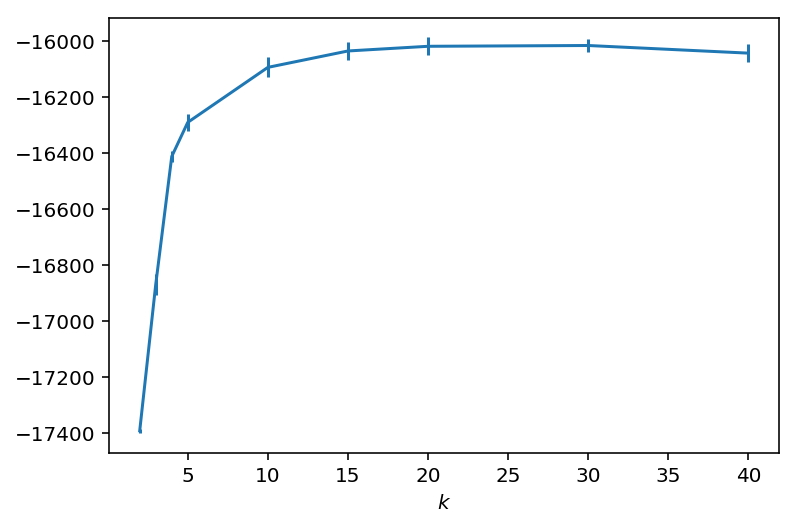

In [53]:
errorbar(kvals,mean(q_mat,axis=0),std(q_mat,axis=0))
xlabel(r'$k$')
savefig('CrossValidation.pdf')

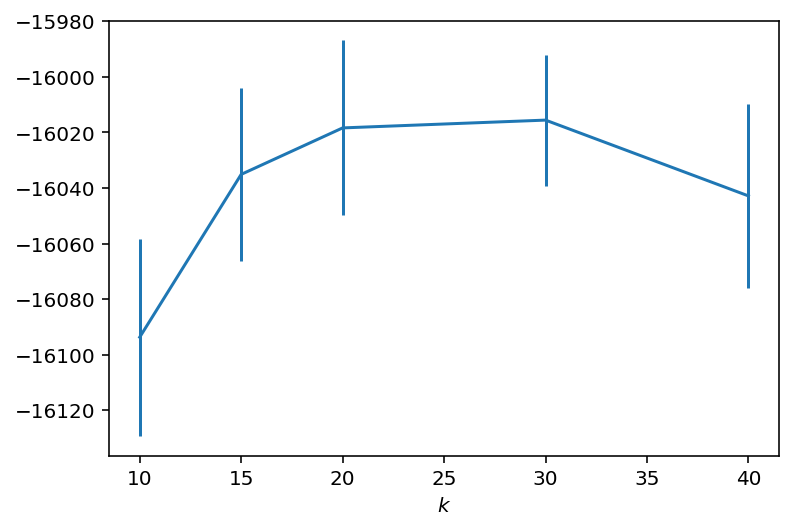

In [54]:
errorbar(kvals[4:],mean(q_mat,axis=0)[4:],std(q_mat,axis=0)[4:])
xlabel(r'$k$')
savefig('kMax.pdf')

It looks like $k\approx 25$ best fits the data!